## Exercise about sparse neural networks and SHAP values
##### Karl-Axel Jönsson BME4


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import collections 
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch

import xgboost
import shap
shap.initjs()

from sklearn import preprocessing

In [2]:
"""
Read all files necessary for the notebook. These are all available in the GitHub repo.
"""
data_matrix = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/main/data/QuantMatrix.csv')
design_matrix = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/main/data/inner_design_matrix.tsv', sep="\t")
G = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/main/data/pathways.tsv', sep="\t")
translation = pd.read_csv('https://raw.githubusercontent.com/ErikHartman/BMEN35/main/data/translation.tsv', sep="\t")
human_proteome = pd.read_csv('https://github.com/ErikHartman/BMEN35/blob/main/data/human_proteome.gz?raw=true', compression="gzip")


In [3]:
display(G)

,parent,child
0,R-HSA-109581,R-HSA-109606
1,R-HSA-109581,R-HSA-169911
2,R-HSA-109581,R-HSA-5357769
3,R-HSA-109581,R-HSA-75153
4,R-HSA-109582,R-HSA-140877
...,...,...
2598,R-HSA-983705,R-HSA-983695
2599,R-HSA-983712,R-HSA-2672351
2600,R-HSA-983712,R-HSA-936837
2601,R-HSA-991365,R-HSA-170670


In [4]:
def get_proteins_triv_name(proteins, proteome):
  """
  This is just a function that maps UniProt IDs to more trivial names and is used later.
  """
  proteome['accession'] = proteome['accession'].apply(lambda x: x.split('_')[0])
  names = []
  for protein in proteins:
      if protein in proteome['accession'].values:
          m = proteome.loc[proteome['accession'] == protein]['trivname'].values
          assert len(m) == 1
          m = m[0].split('_')[0]
      else:
          m = protein
      names.append(m)
  return names

#Part 1
In this section we'll dive into graphs, and how they can be used to create sparse neural networks.

The main package for graph processing in Python is called NetworkX (https://networkx.org/documentation/stable/index.html). A graph can be represented in various ways - I usually work with edge lists, and represent them in Pandas DataFrames (NetworkX has a nice functionality which allows the reading of edgelists right into graphs through `networkx.from_pandas_edgelist()`). Therefore, it is not necessary to actually use NetworkX in this exercise (you definitely can in task 1 though, and I've imported it as nx above).

The first task is composed as follows: suppose we have some input, *P*, and a directed graph, *G*, and we want to subset *G* to create a subgraph, *H*, defined so that no nodes without incoming edges in *G* is not in *P*. This formulation is a bit tricky to comprehend at first, but it's very simple when you realize what it actually means. We just want to subset *G* so that all the nodes in it originates from nodes in *P*. 

When we have our subsetted graph, we want to turn it into a neat layered structure so that we then can create a sequential neural network from it. This is slightly complicated, and omitted from the task. You will be presented with "connectivity matrices" which tell us if nodes are connected or not. This is what we will use to generate a sparse neural network through *pruning*. 


         parent          child
0  R-HSA-109581   R-HSA-109606
1  R-HSA-109581   R-HSA-169911
2  R-HSA-109581  R-HSA-5357769
3  R-HSA-109581    R-HSA-75153
4  R-HSA-109582   R-HSA-140877


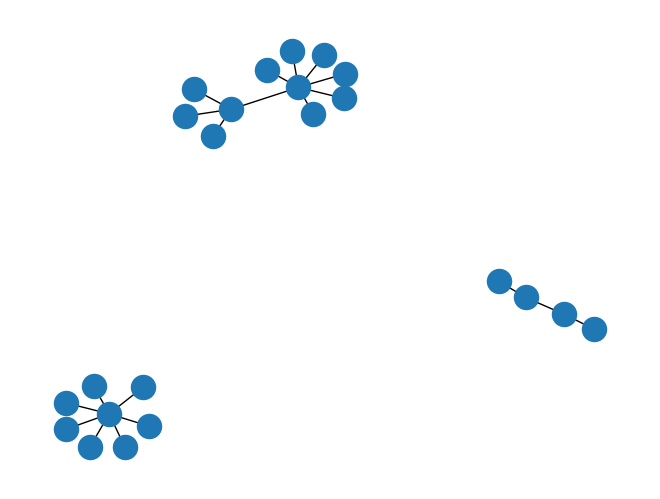

In [5]:
# The graph G

"""
Look up some of the Reactome IDs for your own understanding of the data.
"""
print(G.head())

G_el=nx.from_pandas_edgelist(G.head(20), source='parent', target='child')
nx.draw(G_el)

In [6]:
# To map the reactome IDs to our input (UniProt ids) we need a translation map.
translation[['input','translation']].head()

,input,translation
0,A0A075B6P5,R-HSA-166663
1,A0A075B6P5,R-HSA-173623
2,A0A075B6P5,R-HSA-198933
3,A0A075B6P5,R-HSA-202733
4,A0A075B6P5,R-HSA-2029481


In [ ]:
"""
Our input is a data matrix with certain proteins involved. This is P.
"""
P = data_matrix['Protein'].values
P

In [8]:
def subset_on_proteins_in_ms_data(P, translation):
  print(f"Number of proteins in translation before subsetting: {len(list(translation['input'].unique()))}")
  translation = translation[translation['input'].isin(P)]
  print(f"Number of proteins in translation after subsetting: {len(list(translation['input'].unique()))}")
  return translation
translation = subset_on_proteins_in_ms_data(P, translation)
translation[['input' ,'translation']]

Number of proteins in translation before subsetting: 11613
Number of proteins in translation after subsetting: 458


,input,translation
125,A0M8Q6,R-HSA-166663
126,A0M8Q6,R-HSA-173623
127,A0M8Q6,R-HSA-198933
128,A0M8Q6,R-HSA-202733
129,A0M8Q6,R-HSA-2029481
...,...,...
49220,Q9Y4L1,R-HSA-3000484
49221,Q9Y4L1,R-HSA-3000484
49222,Q9Y4L1,R-HSA-381038
49734,Q9Y6Z7,R-HSA-166662


## Task 1

The translation from proteins to low level processes is now subsetted on proteins in P. Now comes the tricky part (your task): subset G on the translation. This can be done in multiple ways - the one I implemented first just used DataFrame objects and lists. I've also implemented it using networkX and graph manipulation. Feel free to try any way you like. This is the most difficult algorithm of the exercise.

If you've reached a method you're happy with you can check against my results: the subsetted graph should have an edge list with 1003 rows. 

##### Attempt 1


In [9]:

# H = pd.DataFrame(columns=['parent', 'child'])

# i = 0
# while(i < len(translation)):
#   child = translation['translation'].iloc[i]
  
#   while(G['child'].str.contains(child).any()):
#     idx = G[G['child']==child].index.values[0]

#     if (i == 0 and len(H) == 0) :
#         H.loc[0] = G['parent'].iloc[idx], G['child'].iloc[idx]
        
#     else :
#         h_idx = H.index[-1] + 1
#         H.loc[h_idx] = G['parent'].iloc[idx], G['child'].iloc[idx]
        

#     child = G['parent'].iloc[idx]
    
#   i = i + 1


##### Attempt 2

In [10]:
H = pd.DataFrame(columns=['parent', 'child'])

list=G[G['child'].isin(translation['translation'])]
while (len(list) !=0):
    H = pd.concat([H,list])
    list=G[G['child'].isin(list['parent'])]

H=H.groupby(['parent','child']).size().reset_index().drop(columns=[0])

if len(H) == 1003:
    print("Nice")
else:
    print("Sorry")

Nice


Once *H* is created, some more graph manipulation happens to in the end end up with the connectivity matrices which are defined below.

In [11]:
matrices = {}
for i in range(5):
  m = pd.read_csv(f"https://raw.githubusercontent.com/ErikHartman/BMEN35/main/data/matrix_{i}.csv", index_col='Unnamed: 0')
  matrices[i] = m

print(matrices[0].shape)

(449, 443)


## Task 2
Now comes your second task - which is to generate a sparse sequential-object in Pytorch (see https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The connections should be defined as per the connectivity matrices above. A connection in the connectivity matrix is represented as a 1, while the lack of a connection is represented as a 0. I'll give you a hint on how to do that: *pruning* (notice the pruning import from torch.nn.utils above).

The output should be a model of typ nn.Sequential! You can put any intermediary layers that you'd like in there. The nn.Sequential object is the core of the Pytorch neural network class (if creating a sequential model) - once you know how to create this the rest is easy.

Pytorch is the most advanced (and used) library for artificial neural networks in Python. It's dissimilar to keras and TensorFlow, and therefore has a little bit of a learning curve - but it's worth it.

In [12]:

n_inputs = len(matrices[0])   
n_outputs = len(matrices[4])

n_hidden1 = len(matrices[1])
n_hidden2 = len(matrices[2])
n_hidden3 = len(matrices[3])
n_hidden4 = len(matrices[4])


model = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, n_hidden1),
    torch.nn.Linear(n_hidden1, n_hidden2),
    torch.nn.Linear(n_hidden2, n_hidden3),
    torch.nn.Linear(n_hidden3, n_hidden4),
    torch.nn.Linear(n_hidden4, n_outputs)
)

for i,child in enumerate(model.children()):
    prune.custom_from_mask(child, name='weight', mask=torch.Tensor(matrices[i].values.T))




## Congratulations!
You've now created a sparse model in Pytorch from a graph. A minimal example of how the Sequential object is integrated into a Pytorch neural network can be seen below. There is quite a lot of work to create a training/testing loop in Pytorch (without much reward) so I figured I'd leave that out for this exercise. 

In [20]:
class SparseNeuralNet(nn.Module):

    def __init__(self):
        super(Net, self).__init__(Sequential : nn.Sequential)
        self.model = torch.nn.Sequential()

    def forward(self, x):
      # The forward method just passes the data through the sequential model!
        x = self.model(x)
        return x
    """
    You would also define other functions, such as what the training and testing
    loops should do, what loss function to use etc etc.
    """
nn = SparseNeuralNet(model) # you can input your sequential model here if you'd like
nn

SyntaxError: invalid syntax (2042975614.py, line 4)

# Part 2

Now it's time to dive in to SHAP! This is a bit more relaxed, and you'll get to create your own pretty figures.

In [14]:
"""
The data comes consists of a "data matrix" and a "design matrix".
The data matrix contains the actual data, whereas the design matrix contains
information about which sample is in each group.
"""

group_one_samples = design_matrix[design_matrix['group'] == 1]['sample'].values
group_two_samples = design_matrix[design_matrix['group'] == 2]['sample'].values
data_matrix.head()

,Protein,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,TM_M2012_010,TM_M2012_011,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,22.381866,22.773908,22.732549,22.960530,22.906198,23.167862,23.122564,23.110142,23.179716,...,23.416677,23.498007,23.459972,23.403313,23.454894,23.602666,23.682634,23.665858,24.015710,23.655648
1,P02671,25.349974,25.431340,25.459891,25.275259,25.592789,24.829806,24.208987,23.984077,26.075865,...,24.984516,25.023149,24.971465,23.369445,24.604836,24.623221,24.787905,25.095571,25.103341,24.914344
2,P01042,22.061788,21.872170,21.966596,22.256140,22.505168,22.993978,23.277504,22.963205,22.767097,...,22.953879,23.089170,23.018547,23.280626,23.503529,23.471356,23.471414,23.193750,24.101306,23.486766
3,P00450,22.647246,23.193086,23.332780,23.206429,22.959381,23.008403,22.770807,22.971128,23.373016,...,23.788756,23.932623,23.904721,23.273831,23.462794,23.783564,23.968122,23.956618,23.989086,23.834912
4,P05156,21.301448,21.435684,21.304184,21.459141,21.532018,22.006447,21.968122,21.688934,21.372610,...,21.850530,21.883567,21.936084,21.778412,22.051000,22.187546,21.965964,21.820840,22.373783,22.076671


In [15]:
protein_labels = get_proteins_triv_name(data_matrix['Protein'].values, human_proteome) # the UniProt IDs are translated to more common names.

df1 = data_matrix[group_one_samples].T 
df2 = data_matrix[group_two_samples].T
df1.columns = protein_labels
df2.columns = protein_labels

y = np.array([0 for x in group_one_samples] + [1 for x in group_two_samples]) # this is our Y 
df_X = pd.concat([df1,df2]).fillna(0)
X = df_X.to_numpy()
scaler = preprocessing.StandardScaler().fit(X) # makes mean = 0 and variance = 1
X_scaled = scaler.transform(X) # this is our scaled X

df_X_scaled = pd.DataFrame(X_scaled) # puts everything into a pandas DataFrame
df_X_scaled.columns = df_X.columns
df_X_scaled

,CFAH,FIBA,KNG1,CERU,CFAI,CO1A1,CO7,IGLL5,TRFE,HPT,...,P01616,CTRB1,MFAP4,4F2,P18136,CSF1R,PSME1,TIMP2,FSTL3,RB27B
0,0.474120,-1.748935,0.568842,-0.554017,0.420675,-1.626960,0.474942,0.549018,1.353755,-0.247690,...,0.607345,-0.253816,-0.456284,-0.316671,-0.589943,1.354016,-0.191647,-0.535355,-0.124093,-0.071429
1,0.699739,2.301029,0.059307,0.377119,-0.145055,0.589385,-0.549855,-1.470286,-0.579473,0.178393,...,0.000225,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
2,0.616734,0.747695,0.528698,1.046836,0.078350,0.587803,-0.058332,-1.195053,0.025206,0.419302,...,-0.074833,-0.253816,2.139618,-0.316671,-0.589943,-0.708802,-0.191647,1.802819,-0.124093,-0.071429
3,1.606663,0.302478,1.550630,1.738238,0.690851,0.415007,0.303058,-1.215262,0.025584,0.617930,...,-0.029424,-0.253816,2.218473,-0.316671,-0.589943,1.175290,-0.191647,-0.535355,-0.124093,-0.071429
4,1.416180,1.772326,1.499721,1.163521,0.373920,0.255424,0.178799,-1.137548,-0.370086,0.508600,...,-0.042314,-0.253816,2.143739,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2.071304,-0.511473,1.889137,1.328322,1.312417,0.696954,-0.059947,-0.007676,2.551985,-2.530578,...,-0.431806,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
193,2.330629,-0.192622,1.889287,1.755925,0.916130,0.619886,0.359412,-0.093331,2.396032,-3.784795,...,-0.151382,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429
194,2.276228,0.403057,1.167853,1.729271,0.656582,0.553426,0.930050,0.198921,2.322438,-4.093601,...,0.568234,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,5.318793,-0.535355,-0.124093,-0.071429
195,3.410748,0.418100,3.525893,1.804496,1.645494,0.177873,2.182560,0.293043,1.227210,-2.100192,...,0.405155,-0.253816,-0.456284,-0.316671,-0.589943,-0.708802,-0.191647,-0.535355,-0.124093,-0.071429


### Task 1
Now you have generated the data and put it in a dataframe. The rows in the dataframe are the samples and the columns the proteins. The values in the dataframe are the scaled protein abundances.

Now it's time to train a classifier. This time you'll use the xgboost package to train a boosted tree on the data. Implement a training algorithm and see what the accuracy is. It would be best to implement cross-validation when we have so few datapoints. 

In [17]:
""" Train and test how accuarge the XGBoost model is on the data here.
Import the necessary packages. Sci-kit learn is available by default in Google Collab
so there is no need to !pip install if you're using that package. """
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.2)

xgb_model=xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

y_hat=xgb_model.predict(X_test)
accuracy_score(y_test, y_hat)



0.8670886075949367

### Task 2

Now it's time to introspect the model, and see what proteins it thinks is important for the classification of very severy septic AKI and less severe septic AKI. For this we will use the SHAP package.

If you thorougly want to understand SHAP values, I recommend the original paper by Scott Lundberg:  https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf. The documentation is also very nice if you don't care about the background: https://shap-lrjball.readthedocs.io/en/latest/

I want you to create some plot which is presented in the SHAP package which visualizes what proteins are improtant in the data. The simplest plot to create is a summary plot! Feel free to explore any plots you'd like - they're all really pretty.

* NOTE: For SHAP we'd like to train a new model on the complete dataset! We don't care about validation - we just want the model to be as trained as possible.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


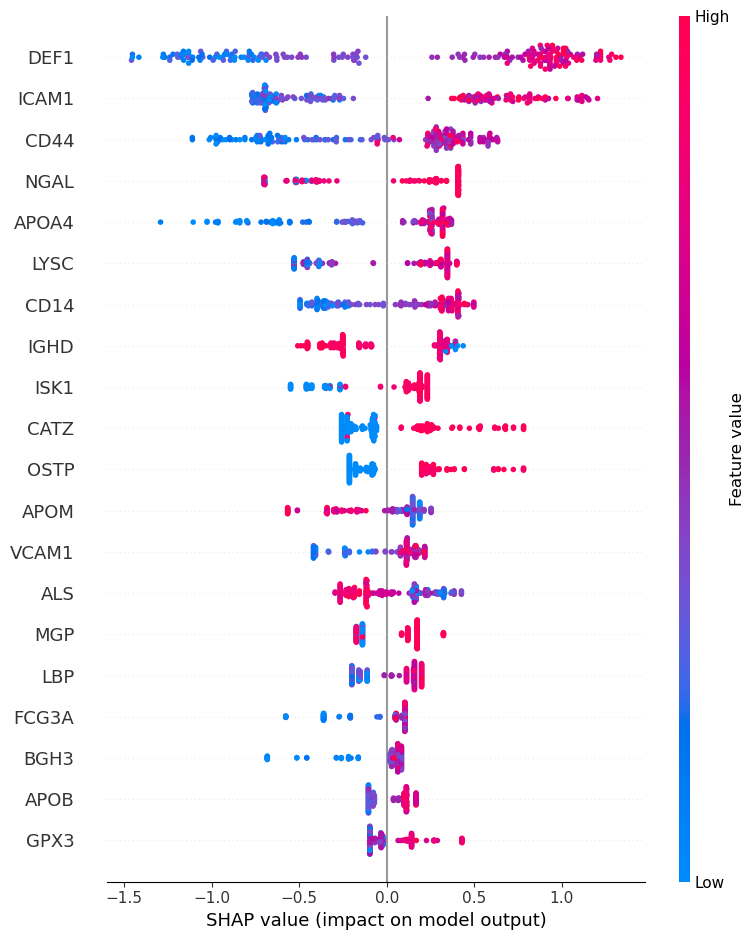

In [18]:
""" Create some SHAP plots here! Feel free to stylize them and do whatever you'd like"""
xgb_model=xgb.XGBClassifier()
xgb_model.fit(X, y)

xplain=shap.TreeExplainer(xgb_model)
shap_values = xplain.shap_values(X)

shap.summary_plot(shap_values, df_X_scaled)


#### Task 2.1
Once you've found the most important protein - look for some publications/litterature to make sense of some of the top proteins? Is the data reasonable?

The data seems reasonable since they all take part in some kind of inflammatory process as sepsis do generates.